[시계열수치입력 수치예측 모델](https://tykimos.github.io/2017/09/09/Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe/)<br>
[Scikit_learn의 전처리기능-스케일링-](https://datascienceschool.net/view-notebook/f43be7d6515b48c0beb909826993c856/)  
아래 내용은 상위 링크를 정리한것.

# 시계열수치입력 수치예측 모델

각 모델에 cosine(코사인)데이터를 학습 시킨 후, <br>
처음 일부 데이터를 알려주면 이후 코사인 형태의 데이터 예측을 얼마나 잘 하는지 테스트한다.<br>

## 데이터셋 준비

시간의 흐름에 따라 진폭이 -1.0에서 1.0사이로 변하는 1,600개의 실수값을 생성한다.

In [9]:
import numpy as np

signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

생성된 데이터를 확인해본다.

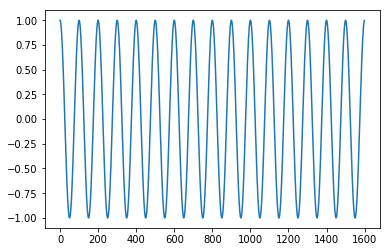

In [12]:
import matplotlib.pyplot as plt

plot_x = np.arange(1600)
plot_y = signal_data
plt.plot(plot_x, plot_y)
plt.show()

생성한 코사인 데이터를 모델에 학습시키기 위해서는 데이터와 라벨로 구성된 데이터셋으로 만들어야 한다.<br>
* **이전 수치들은**<br>
입력하여 다음 수치를 예측하는 문제이므로 데이터는 이전 수치들이 되고,<br>
* **라벨은**<br>
다음 수치가 된다.

다른예제들과는 달리 데이터와 라벨이 모두 같은 속성이다.<br>
아래 crate_dataset() 메소드는 시계열 수치를 입력받아 데이터 셋을 생성한다.<br>
이 때 <br>
* **look_back 인자는** <br>
얼마만큼의 이전 수치를 데이터로 만들 것인가를 결정한다.<br>

In [13]:
signal_data

array([[1.        ],
       [0.99802673],
       [0.9921147 ],
       ...,
       [0.98228725],
       [0.9921147 ],
       [0.99802673]])

In [34]:
def create_dataset(signal_data, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i : (i + look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

-1.0에서 1.0까지의 값을 가지는 코사인 데이터를 0.0과 1.0 사이의 값을 가지도록 정규화를 한 뒤 훈련셋과 시험셋으로 분리한다.(Scalering과정)  
이전 20개의 수치를 입력하여 다음 수치 1개를 예측하는 데이터셋을 만들기 위해 look_back인자를 40으로 설정한다.  
**look_back 인자에 따라 모델의 성능이 달라지므로 적정 값을 지정하는 것이 중요하다.**  
그러나 look_back 인자가 어떻게 성능을 결정하는지에 대한 의문이 아직 있다.  
자세한 내용은 추가하도록 한다.

In [35]:
from sklearn.preprocessing import MinMaxScaler

look_back = 40

#데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
singnal_data = scaler.fit_transform(signal_data)

#데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

#데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
c_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

## 레이어 준비

|블록|이름|설명|
|---|---|---|
|![LSTM](http://tykimos.github.io/warehouse/DeepBrick/Model_Recipe_Part_LSTM_s.png)|LSTM|Long-Short Term Memory unit의 약자로 순환 신경망 레이어중 하나이다.|
|![than](http://tykimos.github.io/warehouse/DeepBrick/Model_Recipe_Part_Activation_tanh_s.png)|tanh|LSTM의 출력 활성화 함수로 사용된다.|

아래 그림은 4개의 타임스텝을 가진 LSTM을 표시한것이다.  
출력 활성화 함수로 tanh를 사용하였다.  
그림에는 타임스텝에 따라 별도의 블록으로 형상화하나, 내부적으로 모든 블록은 같은 가중치를 사용한다.  
![LSTM-image](http://tykimos.github.io/warehouse/DeepBrick/Model_Recipe_Part_LSTM_Example_m.png)

## 모델 준비
시계열수치를 입력하여 수치를 예측하기 위해 **다층퍼셉트론 모델**, **순환신경망 모델**, **상태유지 순환신경망 모델**, **상태유지 스택 순환신경망 모델**을 사용한다.  

### 다층퍼셉트론 모델

Dense 레이어가 4개인 다층퍼셉트론 모델이다.  
은닉층에서 사용된 Dense레이어는 32개의 뉴런을 가지고 있고, **ReLU**활성화 함수를 사용한다.  
출력층의 Dense 레이어는 하나의 수치값을 예측하기 위해서 1개의 뉴런을 가지며,  
별도의 활성화 함수를 사용하지 않았다.  
과적합을 방지하기 위해 Dropout레이어가 삽입된다.  

![다층퍼셉트론 모델](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_1m.png)

### 순환신경망 모델
한 개의 LSTM 레이어를 이용하여 순환신경망 모델을 구성한 그림이다.  
출력층은 하나의 수치값을 예측하기 위해 1개 뉴런을 가진  Dense 레이어를 사용한다.

In [ ]:
model = Sequential()
model.add(LSTM(32, input_shape=(None, 1)))
model.add(Dropout(0.3))
model.add(Dense(1))

![](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_2m.png)

### 상태유지 순환신경망 모델
순환신경망 모델과 동일하나 'stateful = True'옵션을 사용하여 상태유지 가능한 순환신경망 모델을 구성하였다.  
상태유지 모드일 경우 한 배치에서 학습된 상태가 다음 배치 학습 시에 전달되는 방식이다.
```python
model = Sequential()
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))
```
![](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_3m.png)

### 상태유지 스택 순환신경망 모델
상태유지 순환신경망을 여러겹 쌓아올린 모델이다.  
층이 하나인 순환신경망에 비해 더 깊은 추론이 가능한 모델이다.  
```python
model = Sequential()
for i in range(2):
    model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
    model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))
```
![](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_4m.png)

## 전체 소스
### 다층퍼셉트론 모델

In [1]:
# 사용할 패키지 로드
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0]) ## [i:(i+look_back), 0] x row 값을 지정하는 append.
                                                      ## look_back이 클수록 x값도 커진다.
        dataY.append(signal_data[i + look_back, 0]) ## [i + look_back, 0] 지정된 x값을 제외한 한개의 y row값
    return np.array(dataX), np.array(dataY)

look_back = 40

# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(1600) * (20 * np.pi/1000))[:,None]

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1)) ## 0~1까지 Nomeralize
signal_data = scaler.fit_transform(signal_data) ## signal_data를 Nomeralize 변수에 적용

# 데이터 분리
train = signal_data[0:800] ## 0에서 799번째 위치 까지의 데이터를 train 데이터로 생성
val = signal_data[800:1200] ## 800번째 부터 1199번 위치까지의 데이터를 val데이터로 생성
test = signal_data[1200:] ## 1200부터 마지막위치까지 데이터를 test데이터로 생성

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리 ## 다시 이해 해보기
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_train = np.squeeze(x_train)
x_val = np.squeeze(x_val)
x_test = np.squeeze(x_test)

Using TensorFlow backend.


In [2]:
# 2. 모델 구성하기
model = Sequential()
model.add(Dense(32, input_dim=40, activation="relu"))
model.add(Dropout(0.3))
for i in range(2):
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
model.add(Dense(1))

In [3]:
# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adagrad') ## mean squared error 다시 공부하기

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val))

Train on 760 samples, validate on 360 samples
Epoch 1/200
760/760 [==============================] - 67s 88ms/step - loss: 0.1850 - val_loss: 0.0427
Epoch 2/200
760/760 [==============================] - 0s 229us/step - loss: 0.0724 - val_loss: 0.0118
Epoch 3/200
760/760 [==============================] - 0s 317us/step - loss: 0.0616 - val_loss: 0.0252
Epoch 4/200
760/760 [==============================] - 0s 279us/step - loss: 0.0475 - val_loss: 0.0042
Epoch 5/200
760/760 [==============================] - 0s 225us/step - loss: 0.0426 - val_loss: 0.0236
Epoch 6/200
760/760 [==============================] - 0s 216us/step - loss: 0.0393 - val_loss: 0.0145
Epoch 7/200
760/760 [==============================] - 0s 229us/step - loss: 0.0348 - val_loss: 0.0151
Epoch 8/200
760/760 [==============================] - 0s 228us/step - loss: 0.0347 - val_loss: 0.0179
Epoch 9/200
760/760 [==============================] - 0s 248us/step - loss: 0.0349 - val_loss: 0.0116
Epoch 10/200
760/760 [=====

760/760 [==============================] - 0s 219us/step - loss: 0.0108 - val_loss: 0.0095
Epoch 158/200
760/760 [==============================] - 0s 277us/step - loss: 0.0109 - val_loss: 0.0072
Epoch 159/200
760/760 [==============================] - 0s 224us/step - loss: 0.0109 - val_loss: 0.0070
Epoch 160/200
760/760 [==============================] - 0s 255us/step - loss: 0.0111 - val_loss: 0.0087
Epoch 161/200
760/760 [==============================] - 0s 249us/step - loss: 0.0109 - val_loss: 0.0070
Epoch 162/200
760/760 [==============================] - 0s 308us/step - loss: 0.0100 - val_loss: 0.0087
Epoch 163/200
760/760 [==============================] - 0s 345us/step - loss: 0.0099 - val_loss: 0.0080
Epoch 164/200
760/760 [==============================] - 0s 315us/step - loss: 0.0118 - val_loss: 0.0088
Epoch 165/200
760/760 [==============================] - 0s 186us/step - loss: 0.0105 - val_loss: 0.0080
Epoch 166/200
760/760 [==============================] - 0s 225us/ste

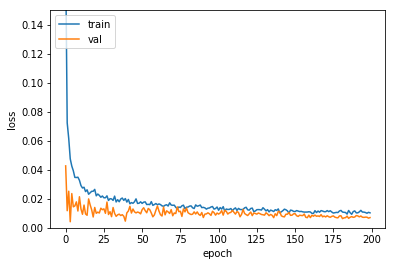

In [4]:
# 5. 학습과정 살펴보기
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim(0.0, 0.15) ##???????
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [5]:
# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, verbose=0)
print('Validation Score: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score : ', testScore)

Train Score:  0.00702663758574
Validation Score:  0.00703820122613
Test Score :  0.00702663758574


### 7. 모델 사용하기

~~look_ahead에 왜 250 주나?~~ look_ahead 값을 이용하여 x 값의 범위를 지정하고 있다.

In [ ]:
look_ahead = 250 
 
xhat = x_test[0, None]
predictions = np.zeros((look_ahead, 1))
for i in range(look_ahead):
    prediction = model.predict(xhat, batch_size=32)
    predictions[i] = prediction
    xhat = np.hstack([xhat[:, 1:], prediction])
    
plt.figure(figsize=(20, 10))
plt.plot(np.arange(look_ahead), predictions, 'r', label='prediction')
plt.plot(np.arange(look_ahead), y_test[:look_ahead], label="test function")

~~y_test가 이해되지 않음~~ y_test의 범위는 look_ahead 값 이전까지 범위를 지정하고 plot을 이용하여 test function 라인을 그리고 있다. 

In [ ]:
plt.legend()
plt.show()

모형은 이상하나 비슷한 주기를 그린다.

### 순환신경망 모델

In [1]:
# 패키지 로드
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
# 데이터 셋 생성 메소드
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0]) # 0부터 전체 데이터길이 까지에서 row값을 
                                                      # look_back을 까지값을 x로 변환
        dataY.append(signal_data[i+look_back, 0]) # 한개의 row를 y값으로 설정
    return np.array(dataX), np.array(dataY)

look_back = 40

# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(1600) * (20 * np.pi/1000)) [:,None]

In [3]:
# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1)) # scaler을 0에서 1사이 값으로 한다.
signal_data = scaler.fit_transform(signal_data)

In [4]:
# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) ## shape 아직 공부하지 못함
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [5]:
# 2.모델 구성하기
model = Sequential()
model.add(LSTM(32, input_shape=(None, 1)))
model.add(Dropout(0.3))
model.add(Dense(1))

In [6]:
# 3.학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')

In [7]:
# 4. 모델 학습시기키
hist = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val))

Train on 760 samples, validate on 360 samples
Epoch 1/200
760/760 [==============================] - 5s 6ms/step - loss: 0.2129 - val_loss: 0.0393
Epoch 2/200
760/760 [==============================] - 2s 3ms/step - loss: 0.0384 - val_loss: 0.0270
Epoch 3/200
760/760 [==============================] - 2s 3ms/step - loss: 0.0306 - val_loss: 0.0169
Epoch 4/200
760/760 [==============================] - 2s 3ms/step - loss: 0.0207 - val_loss: 0.0115
Epoch 5/200
760/760 [==============================] - 2s 3ms/step - loss: 0.0160 - val_loss: 0.0063
Epoch 6/200
760/760 [==============================] - 2s 3ms/step - loss: 0.0118 - val_loss: 0.0023
Epoch 7/200
760/760 [==============================] - 2s 3ms/step - loss: 0.0088 - val_loss: 0.0019
Epoch 8/200
760/760 [==============================] - 2s 3ms/step - loss: 0.0082 - val_loss: 8.8880e-04
Epoch 9/200
760/760 [==============================] - 2s 3ms/step - loss: 0.0068 - val_loss: 8.6808e-04
Epoch 10/200
760/760 [===============

Epoch 155/200
760/760 [==============================] - 2s 3ms/step - loss: 0.0020 - val_loss: 6.3730e-05
Epoch 156/200
760/760 [==============================] - 2s 3ms/step - loss: 0.0019 - val_loss: 6.7079e-05
Epoch 157/200
760/760 [==============================] - 2s 3ms/step - loss: 0.0018 - val_loss: 9.3189e-05
Epoch 158/200
760/760 [==============================] - 2s 3ms/step - loss: 0.0023 - val_loss: 9.1253e-05
Epoch 159/200
760/760 [==============================] - 3s 3ms/step - loss: 0.0022 - val_loss: 3.6361e-05
Epoch 160/200
760/760 [==============================] - 2s 3ms/step - loss: 0.0018 - val_loss: 2.2002e-04
Epoch 161/200
760/760 [==============================] - 2s 3ms/step - loss: 0.0020 - val_loss: 6.7036e-05
Epoch 162/200
760/760 [==============================] - 2s 3ms/step - loss: 0.0020 - val_loss: 6.9344e-05
Epoch 163/200
760/760 [==============================] - 2s 3ms/step - loss: 0.0020 - val_loss: 4.9069e-05
Epoch 164/200
760/760 [==============

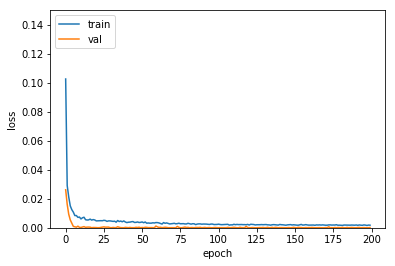

In [15]:
# 5. 학습과정 살펴보기
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim(0.0, 0.15) # plot에서 나타나는 한계 y지정
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, verbose=0)
model.reset_states() # 모델 초기화?
print('valScore: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

Train Score:  0.00019829987156155864
valScore:  0.00020308087502295772
Test Score:  0.00020308087502295772


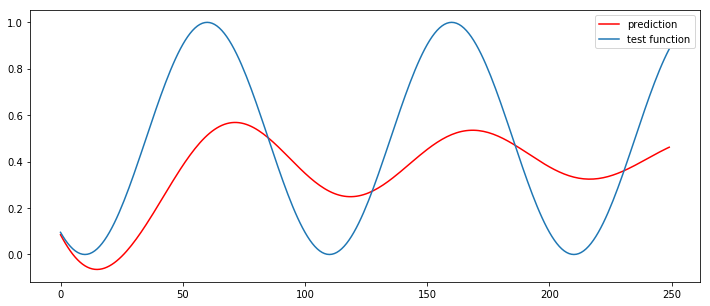

In [21]:
# 7. 모델 사용하기
look_ahead = 250 #???
xhat = x_test[0]

predictions = np.zeros((look_ahead, 1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])
    
plt.figure(figsize=(12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label="prediction")
plt.plot(np.arange(look_ahead), y_test[:look_ahead], label="test function")
plt.legend()
plt.show()

## 상태유지 순환신경망 모델

In [13]:
# 패키지로드
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt

In [14]:
def create_dataset(singnal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0]) ## look_back 길이까지 x data로 사용
        dataY.append(signal_data[i+look_back, 0]) ## loock_back 길이 이후부터 y data로 사용
    return np.array(dataX), np.array(dataY)

In [15]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

In [16]:
look_back = 40

In [17]:
# 데이터셋 생성하기 
signal_data = np.cos(np.arange(1600) * (20*np.pi/1000))[:,None]

In [18]:
# 데이터 전처리
# 원본
scaler = MinMaxScaler(feature_range=(0, 1)) ##? 이렇게 안해도 될것 같다..
signal_data = scaler.fit_transform(signal_data)

In [19]:
signal_data

array([[ 1.        ],
       [ 0.99901336],
       [ 0.99605735],
       ..., 
       [ 0.99114363],
       [ 0.99605735],
       [ 0.99901336]])

In [20]:
# 수정본
# signal_data = MinMaxScaler(signal_data) ##?? 이렇게 해도 가능한것으로 알고 있다.

In [21]:
# signal_data

In [22]:
# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

In [23]:
# 데이터셋 생성
x_train, y_train = create_dataset(singnal_data=train, look_back=look_back)
x_val, y_val = create_dataset(singnal_data=val, look_back=look_back)
x_test, y_test = create_dataset(singnal_data=test, look_back=look_back)

In [25]:
x_val.shape ## (행?, 열?)

(1560, 40)

In [26]:
# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) ## shape 아직도 모름
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1)) ## 3차원을 생성한것 같다.
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 
## 즉, x_test의 행을 1560으로 열을 40으로 된것이 1개? 라고 추측된다.

In [27]:
# 2. 모델 구성하기
model = Sequential()
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3)) # node를 랜덤하게 선택하는데 0.3의 비율로 선택 # 앙상블의 효과?
model.add(Dense(1))

In [28]:
# 3. 모델 학습과정 설명하기
model.compile(loss='mean_squared_error', optimizer='adam')

In [29]:
# 4. 모델 학습시키기
custom_hist = CustomHistory()
custom_hist.init()

for i in range(3):
    model.fit(x_train, 
              y_train, 
              epochs=1, 
              batch_size=1, 
              shuffle=False, ## ????
              callbacks=[custom_hist], 
              validation_data=(x_val, y_val))
    model.reset_states()

Train on 1560 samples, validate on 1560 samples
Epoch 1/1
1560/1560 [==============================] - 135s 87ms/step - loss: 0.0169 - val_loss: 0.0021
Train on 1560 samples, validate on 1560 samples
Epoch 1/1
1560/1560 [==============================] - 137s 88ms/step - loss: 0.0053 - val_loss: 0.0011
Train on 1560 samples, validate on 1560 samples
Epoch 1/1
1560/1560 [==============================] - 134s 86ms/step - loss: 0.0040 - val_loss: 8.0046e-05


본문의 760개의 학습 과는 다르게 1560개의 학습이 이루어 지는 것을 확인 할 수 있다.(batch)  
게다가 학습도 굉장히 느리다.  
무엇이 문제인지 확인이 필요하다.  

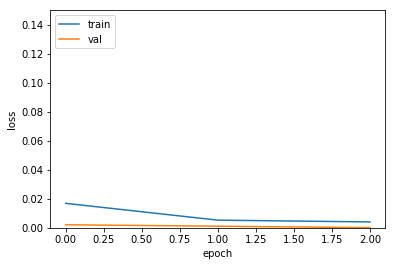

In [30]:
# 학습과정 살펴보기

plt.plot(custom_hist.train_loss)
plt.plot(custom_hist.val_loss)
plt.ylim(0.0, 0.15) ## 그래프 화면 표시 크기 설정
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
# 모델 평가하기
trainScore = model.evaluate(x_train, y_train, batch_size=1, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
model.reset_states()
print('Validatation Score: ', valScore)
testScore = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
model.reset_states()
print('Test Score: ', testScore) 

Train Score:  8.00463392761e-05
Validatation Score:  8.00463392761e-05
Test Score:  8.00463392761e-05


In [32]:
# 7. 모델 사용하기
look_ahead = 250

xhat = x_test[0]

## 아래 부분은 다시 공부할 필요성을 느낀다.
predictions = np.zeros((look_ahead, 1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction]) ####????

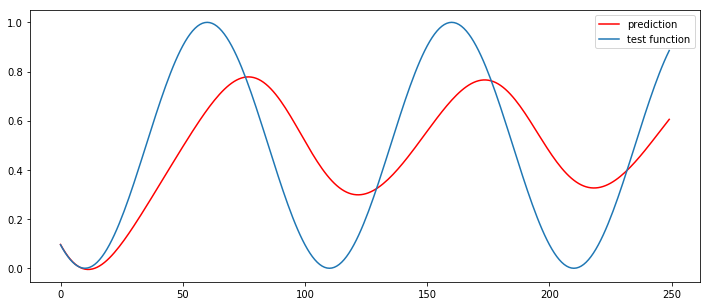

In [33]:
plt.figure(figsize=(12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label='prediction')
plt.plot(np.arange(look_ahead), y_test[:look_ahead], label='test function')
plt.legend()
plt.show()

상위 버전보다는 좋은 진폭을 그리고 있으나 아직 test에 비해 많이 부족한 모습을 보인다.

## 상태유지 스택 순환신경망 모델

In [15]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [3]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

In [4]:
look_back = 40

In [5]:
# 1. 데이터 셋 생성.
signal_data = np.cos(np.arange(1600) * (20 * np.pi/1000))[:,None]
signal_data

array([[1.        ],
       [0.99802673],
       [0.9921147 ],
       ...,
       [0.98228725],
       [0.9921147 ],
       [0.99802673]])

In [6]:
# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data) 
signal_data

array([[1.        ],
       [0.99901336],
       [0.99605735],
       ...,
       [0.99114363],
       [0.99605735],
       [0.99901336]])

In [7]:
# 데이터 분리
train = signal_data[:800]
val = signal_data[800:1200]
test = signal_data[1200:]

In [8]:
# 데이터 셋 생성
x_train, y_train = create_dataset(signal_data=train, look_back=look_back)
x_val, y_val = create_dataset(signal_data=val,look_back=look_back)
x_test, y_test = create_dataset(signal_data=test, look_back=look_back)

In [9]:
x_train.shape

(760, 40)

In [10]:
# 데이터 셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [11]:
# 2. 모델 구성하기
model = Sequential()
for i in range(2):
    model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True, return_sequences = True))
    model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))

In [12]:
# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer = 'adam')

In [13]:
# 4. 모델 학습시키기
custom_hist = CustomHistory()
custom_hist.init()

for i in range(2):
    model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(x_val, y_val))
    model.reset_states()

Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 209s 275ms/step - loss: 0.0802 - val_loss: 0.0503
Train on 760 samples, validate on 360 samples
Epoch 1/1
760/760 [==============================] - 205s 270ms/step - loss: 0.0283 - val_loss: 0.0119


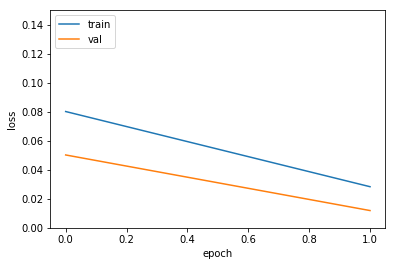

In [16]:
# 5. 학습과정 살펴보기
plt.plot(custom_hist.train_loss)
plt.plot(custom_hist.val_loss)
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, batch_size=1, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)

valScore = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
model.reset_states()
print('Validatation Score: ', valScore)

testScore = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

Train Score:  0.012209390489945056
Validatation Score:  0.01187286028121169
Test Score:  0.01187286028121169


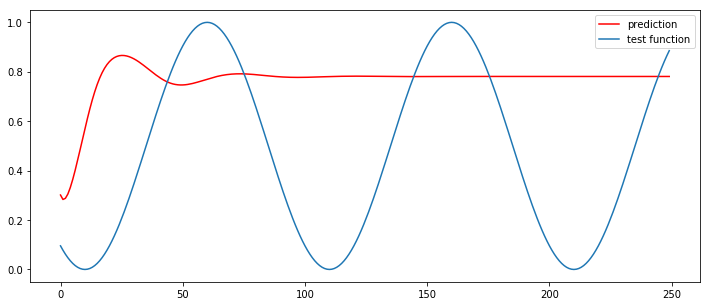

In [20]:
# 7. 모델 사용하기
look_ahead = 250
xhat = x_test[0]
predictions = np.zeros((look_ahead, 1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])
    
plt.figure(figsize=(12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label='prediction')
plt.plot(np.arange(look_ahead), y_test[:look_ahead], label='test function')
plt.legend()
plt.show()

학습을 덜했는지 부족한 모습을 보이고 있다 재학습이 필요하다.